**Name:** Byaravalli Arun Suhag

**EID:** 53265857

# CS4487 - Tutorial 5
## Predicting Popularity of Online News

In this tutorial you will train a regression function to predict the number of "shares" of a news article on Mashable.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
import IPython.utils.warn as warn
random.seed(100)

C:\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


## 1. Loading Data and Pre-processing
Next we need to load the data.  Download `OnlineNewsPopularity.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the data.

In [2]:
filename = 'OnlineNewsPopularity/OnlineNewsPopularity.csv'

# read the data
allfeatnames = []
textdata      = []
with open(filename, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(allfeatnames)==0:
            allfeatnames = row
        else:
            textdata.append(row)

# put the data into a np array
dataX = empty((len(textdata), len(allfeatnames)-3))
dataY = empty(len(textdata))
for i,row in enumerate(textdata):
    # extract features (remove the first 2 features and the last feature)
    dataX[i,:] = array(map(float, row[2:-1]))
    # extract target (last entry)
    dataY[i] = float(row[-1])
    
# extract feature names
featnames = map(string.strip, allfeatnames[2:-1])

# extract a subset of data
dataX = dataX[::6]
dataY = dataY[::6]

print dataX.shape
print dataY.shape

(6608L, 58L)
(6608L,)


There are 58 features for each article.  Here are the feature names, and an example entry.  The actual description of the features can be found in the `OnlineNewsPopularity-features.txt` file.

In [3]:
print featnames

print "--- example article features---"
print dataX[0]
print "--- example article target (# of shares)"
print dataY[0]

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarit

Now separate the data into training and testing sets.

In [4]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainYo, testYo = \
  cross_validation.train_test_split(dataX, dataY, 
  train_size=0.50, test_size=0.50, random_state=4487)

print trainX.shape
print testX.shape

(3304L, 58L)
(3304L, 58L)


Finally, we normalize the input features.

In [5]:
# normalize feature values
# this makes comparing weights more meaningful
scaler = preprocessing.StandardScaler()  
trainXn = scaler.fit_transform(trainX)  
testXn  = scaler.transform(testX)    

Because the target value (number of shares) has a large dynamic range, we will transform the target values through the log function.

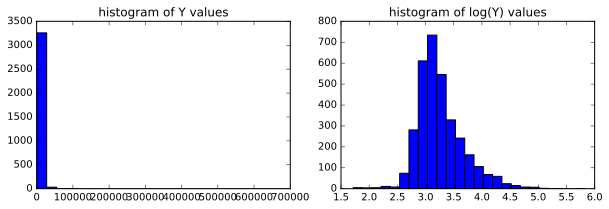

In [6]:
# map targets to log-space
trainY = log10(trainYo)
testY  = log10(testYo)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(trainYo, 25);
plt.title('histogram of Y values')
plt.subplot(1,2,2)
plt.hist(trainY, 25);
plt.title("histogram of log(Y) values");

## 2. Prediction with Linear Regression

First we will look at predicting the number of shares using simple linear regression models.  Use the training data to fit a linear model using Ordinary Least Squares and Ridge Regression.  Use cross-validation on the training set to select the optimal $\alpha$ parameter for ridge regression.

In [10]:
# fit using ordinary least squares

ols = linear_model.LinearRegression()
ols.fit(trainXn, trainY)

# Printing w and b valiue
print "w =", ols.coef_
print "b =", ols.intercept_

# calculate mean-square error on training set
ols_MSE = mean((ols.predict(testXn) - testY)**2)
print "MSE =", ols_MSE

w = [  1.35160390e-02   3.05261793e-02  -1.15127536e-02   1.09816881e+05
   2.31923321e-02   3.16842449e-02  -1.47825843e-02   6.70041698e-03
   5.86335323e-03  -6.20478212e-02   3.83799573e-03  -1.95636831e-02
  -3.50072698e-02  -3.56711695e-02   1.58359631e-02   1.44919999e-02
   8.03022951e-03   2.69996636e-02   5.37429969e-02  -7.85259756e-02
  -6.63881120e-03   2.07749010e-04  -3.33949428e-02  -1.99599892e-02
  -1.15109300e-01   1.89654412e-01   4.66081033e-03   1.46353790e-02
   8.95213876e-03   1.96518050e+11   2.05040412e+11   2.10067822e+11
   2.09188238e+11   1.86113604e+11  -3.06452632e+11  -3.20300294e+11
   6.05461559e+11   3.21283012e+09   2.69688197e+09   3.52789692e+09
   3.64424477e+09   3.56128991e+09   3.87981959e-02  -5.84322956e-03
   3.60880685e-03  -1.16954914e-02  -1.21479878e+05  -9.95557433e+04
   2.42107132e-03  -1.00149232e-02  -2.59627529e-02  -1.35572309e-02
   1.46617442e-02  -7.39431696e-03  -4.73261206e-03   1.80593405e-02
   5.91494423e-04   1.87510127

## Ridge Regression

In [12]:
### Ridge Regression
alphas = logspace(-3,6,50)
rr = linear_model.RidgeCV(alphas=alphas, cv=5)
rr.fit(trainXn, trainY)

# Printing w and b valiue
print "w =", rr.coef_
print "b =", rr.intercept_

# calculate mean-square error on training set
rr_MSE = mean((rr.predict(testXn) - testY)**2)
print rr_MSE

w = [  1.00968216e-02   2.04417085e-02  -3.72629906e-03  -4.30246820e-03
   5.07958617e-03   2.64724471e-02  -1.04070547e-02   7.25330136e-03
   3.82868734e-03  -2.38361817e-02   1.07925646e-02  -1.25766703e-02
  -3.33858798e-02  -2.35051508e-02   1.96764626e-02   1.18741746e-02
  -5.45771720e-03   1.94547472e-02  -6.67878701e-03  -1.13631867e-02
  -8.68840836e-03  -1.97938304e-03  -7.11918104e-03   1.03311628e-02
  -1.66342061e-02   6.30355403e-02   8.16293677e-03   1.23800234e-02
   7.68551008e-03   6.38676872e-03  -8.09850677e-03  -4.78391996e-03
   2.06682358e-03  -9.04907800e-03   4.75842570e-03   1.54823232e-02
   1.49957985e-02   2.79069261e-02  -7.01484307e-03  -3.47817725e-02
   1.42085876e-02   5.19273146e-05   2.90402450e-02  -7.05706372e-04
   2.41987293e-04  -9.46314744e-04  -6.58760378e-03   3.29240346e-03
  -1.74522693e-03  -7.34611304e-03  -1.52555142e-02  -9.06611016e-03
   3.47400779e-03  -6.87855399e-03  -2.78808240e-03   1.51815909e-02
   1.09673446e-03   2.82168924

Compare the two models using the _average absolute error_ (AE) between the predictions and the true values.  Below is  code that will calculate AE for the training and test sets.

In [11]:
# ols is the linear regression model
trainAE = metrics.mean_absolute_error(trainY, ols.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, ols.predict(testXn))
print "OLS: train error = " + str(trainAE)
print "OLS: test error = " + str(testAE)

OLS: train error = 0.28690856998
OLS: test error = 188.89983147


In [13]:
# rr is the ridge regression model
trainAE = metrics.mean_absolute_error(trainY, rr.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, rr.predict(testXn))
print "RR: train error = " + str(trainAE)
print "RR: test error = " + str(testAE)

RR: train error = 0.288985150476
RR: test error = 0.285658555889


Which model has better prediction ability on the test set? Why?
- **Ridge Regression model has better prediction ability on the test set, when compared to Ordinary Least Square model because it has a reduced mean absolute error compared to OLS**
- **This is because of the fact that it uses the regularization term which shrinks  some of the unwanted features, linear weights to zero, which are hence not used to calculate the function output.**

# 3. Which features are important?
Next we will investigate which features are the most important for the prediction.  Use LASSO with cross-validation to learn the model.

In [14]:
las = linear_model.LassoCV()
las.fit(trainXn, trainY)

MSE_las = mean((las.predict(testXn) - testY)**2)
print "MSE =", MSE_las


MSE = 0.144910471977


Examine the LASSO coefficients by sorting them in descending order.

In [15]:
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(las.coef_))[::-1]
# print out
print "weight : feature description"
for i in inds:
    print "% 0.3f : %s" % (las.coef_[i], featnames[i])

weight : feature description
 0.094 : kw_avg_avg
-0.042 : LDA_02
-0.038 : kw_max_avg
-0.034 : data_channel_is_entertainment
-0.027 : average_token_length
 0.025 : global_subjectivity
 0.025 : num_hrefs
 0.022 : kw_min_min
-0.022 : data_channel_is_bus
 0.022 : is_weekend
 0.020 : LDA_00
 0.019 : n_tokens_content
 0.018 : data_channel_is_socmed
-0.018 : kw_avg_min
 0.015 : self_reference_avg_sharess
-0.013 : max_positive_polarity
 0.012 : title_sentiment_polarity
-0.012 : data_channel_is_lifestyle
 0.009 : weekday_is_sunday
-0.008 : LDA_01
-0.007 : avg_negative_polarity
-0.007 : kw_avg_max
 0.007 : n_tokens_title
 0.006 : self_reference_max_shares
 0.006 : num_keywords
-0.006 : kw_min_max
-0.005 : weekday_is_friday
 0.005 : weekday_is_monday
 0.004 : data_channel_is_tech
-0.004 : weekday_is_tuesday
-0.003 : num_self_hrefs
 0.003 : LDA_03
-0.002 : min_positive_polarity
-0.002 : rate_positive_words
 0.002 : num_imgs
 0.002 : self_reference_min_shares
-0.002 : max_negative_polarity
 0.001 :

_Which features are most important for predicting the number of shares?  For these features, which feature values (low or high values) will yield a higher number of shares?_
- **- kw_min_avg: Avg. keyword (min. shares)**
    - High positive value = higher number of shares (positive sign value )
- **LDA_00: Closeness to LDA topic 0**
    - Low negative value = higher number of shares (negative sign value )
- **kw_avg_max: Best keyword (avg. shares)**
    - Low negative value = higher number of shares (negative sign value )
- **num_keywords: Number of keywords in the metadata**
    - Low negative value = higher number of shares (negative sign value )
- **num_imgs: Number of images**
    - Low negative value = higher number of shares (negative sign value )
 
  If we try to make sense of the above observation we find that a high number of keywords, from minimum share posts predicts high number of shares, but this should predict lower number of shares. Same for num_keywords and num_images- one would expect that the higher the number of keywords and images, the higher the number of shares, but the prediction says that these numbers have to be low so as to achieve high number of shares. The above observation does not make much sense for the prediction of number of shares.

On the other hand, the below makes sense for increase in number of shares:

 0.022 :  weekday_is_saturday (if weekday is saturday, high shares)
 0.020 :  weekday_is_sunday (if weekday is sunday, high shares)
 


# 4. Non-linear Regression
Now use non-linear regression to try to improve the prediction accuracy.  Use cross-validation on the training set to select the parameters.  Hint: avoid using large values of $C$ with SVR.

### Kernel Ridge Regression

In [16]:
### INSERT YOUR CODE HERE
gridparams = {'alpha': logspace(-3,3,8),
          'gamma': logspace(-3,3,8)}
krr = grid_search.GridSearchCV(
    kernel_ridge.KernelRidge(kernel='rbf'),  #using rbf kernel ridge regression
    gridparams,                                  
    scoring='mean_squared_error',          # score by mean_squared_error
    cv=5, verbose=1)                               # 5 fold cross validation

krr.fit(trainXn, trainY)

print krr.best_score_
print krr.best_params_



Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   30.6s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  3.6min finished


-0.156438026502
{'alpha': 0.0517947467923121, 'gamma': 0.001}


### Kernel SVR

In [17]:
gridparams = {'C':     logspace(-1,1,8),
          'gamma': logspace(0,1,3),
          'epsilon': logspace(0,0.5,3)}

# do cross-validation with grid_search module.
svr = grid_search.GridSearchCV(
    svm.SVR(kernel='rbf'),  # using rbf-kernel, svr
    gridparams,             
    scoring='mean_squared_error',          # score by mean_squared_error
    cv=5, verbose=1)             # 5 fold cross validation
svr.fit(trainXn, trainY)

print svr.best_score_
print svr.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.7s


-0.230565240618
{'epsilon': 1.0, 'C': 0.71968567300115194, 'gamma': 1.0}


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    4.9s finished


In [18]:
trainAE_krr = mean(abs(krr.predict(trainXn) - trainY))
testAE_krr  = mean(abs(krr.predict(testXn) - testY))
print "KRR Average Absolute Error",testAE_krr

trainAE_krr = mean(abs(svr.predict(trainXn) - trainY))
testAE_krr = mean(abs(svr.predict(testXn) - testY))
print "SVR Average Absolute Error",testAE_krr

KRR Average Absolute Error 0.281213566935
SVR Average Absolute Error 0.4052876719


_Which regression method performs the best? Why do you think so?_
- **Kernel Ridge Regression performs the best out of all the above methods beacuse it has the least Average Absoulte error.**
- **The trend is tracked accurately by Kernel Ridge Regressions because it considers more points as support vectors(infact all the points) by making a better prediction.**